In [116]:
import gymnasium as gym
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

from gymnasium.wrappers.record_video import RecordVideo

from typing import Dict, List, Tuple

In [117]:
plt.ion()

In [118]:
'''
we use this because, otherwise, there would be a high correlation between memories, thus a higher likelihood that we'd select the same few memories,
then leading to some form of over-fitting.
remember that, in Q-learning, we update a guess with a guess. If we selected states that are too "near" each other, it'd be very likely that the update
to Q(s, a) would directly or indirectly alter that of Q(s', a').
'''
class ReplayBuffer:
    # obs_size = state/observable space size
    def __init__(self, max_size: int, obs_size: int, batch_size:int=32):
        self.state_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        # different from pytorch's dqn tutorial, we don't store all actions but rather only the one we take
        self.action_buf = np.zeros(max_size, dtype=np.float32)
        self.reward_buf = np.zeros(max_size, dtype=np.float32)
        self.ns_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        # this will serve as a mask later
        # we use integers because numpy's syntax enables you to assign booleans and they
        # get converted to the dtype
        self.done_buf = np.zeros(max_size, dtype=np.float32)

        self.max_size, self.batch_size = max_size, batch_size
        self.ptr, self.size = 0, 0

    def push(self, 
        state: np.ndarray, 
        action: int, 
        reward: float, 
        ns: np.ndarray, 
        done: bool,
    ):
        idx = self.ptr
        self.state_buf[idx] = state
        self.action_buf[idx] = action
        self.reward_buf[idx] = reward
        self.ns_buf[idx] = ns
        self.done_buf[idx] = done
        
        self.ptr = (idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def sample(self) -> Dict[str, np.ndarray]:
        idx = random.sample(range(self.size), self.batch_size)
        return dict(
            state=self.state_buf[idx],
            action=self.action_buf[idx],
            reward=self.reward_buf[idx],
            ns=self.ns_buf[idx],
            done=self.done_buf[idx],
        )

    def __len__(self):
        return self.size

In [119]:
class Network(nn.Module):
    def __init__(
        self,
        in_size,
        out_size
    ):
        # super().__init__()
        super(Network, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [120]:
class DQNAgent:
    def __init__(self,
        env: gym.Env,
        seed: int,
        memory_size: int,
        batch_size: int,
        target_update: int,
        eps_decay: float,
        max_eps: float = .9,
        min_eps: float = .1,
        gamma: float = .99,
    ):
        self.env = env
        self.seed = seed
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_update = target_update
        self.eps_decay = eps_decay
        self.eps = max_eps
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.gamma = gamma
        obs_size = env.observation_space.shape[0]
        # different from obs_size, we use Discrete, not Box -> https://www.gymlibrary.dev/api/spaces/#discrete
        action_size = env.action_space.n

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        self.memory = ReplayBuffer(10000, obs_size, batch_size)
        
        self.dqn = Network(obs_size, action_size).to(self.device)
        self.dqn_target = Network(obs_size, action_size).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        # we're NOT going to be optimizing the target nn, so this is like a safelock
        self.dqn_target.eval()

        # in the original tutorial, LR is not initialized.. but I think we're fine?
        # self.optimizer = optim.AdamW(self.dqn.parameters(), lr=self.lr, amsgrad=True)
        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)

        self.transition = []

        self.is_test = False

    def choose_action(self, state: np.ndarray) -> int:
        explore = self.eps > np.random.random()
        if explore:
            selected_action = self.env.action_space.sample()
        if not explore or self.is_test:
            # selected_action = self.dqn(self.env.action_space).max(0)[1]
            # the reason why we wrap state in a tensor is because this is how Torch.nn.Module(s) operate. This way,
            # we can easily input a batch.
            selected_action = self.dqn(torch.FloatTensor(state)).argmax().item()
            # "WTF is this??" check: https://stackoverflow.com/a/63869655/15806103
        if not self.is_test:
            self.transition = [state, selected_action]
        return selected_action
    
    def take_step(self, action: int) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        
        done = terminated or truncated
        
        if not self.is_test:
            # in training, self.transition will already look like
            # [state, action]
            # (for ex. if we use take_action(state))
            # so we just add to it!
            self.transition += [reward, next_state, done]
            self.memory.push(*self.transition)
            
        return next_state, reward, done
    
    def compute_dqn(self, samples: dict[str, np.array]):
        """calculate the DQN loss for a batch of memories"""
        device = self.device
        # each of these is a batch/samples of their corresponding name
        state = torch.FloatTensor(samples["state"], device=device)
        ns = torch.FloatTensor(samples["ns"], device=device)
        action = torch.LongTensor(samples["action"], device=device)
        reward = torch.FloatTensor(samples["reward"], device=device)
        done = torch.FloatTensor(samples["done"], device=device)

        # reminder that the target DQN refers to the network that's always a little behind the actual DQN
        # and which we use for the next_state prediction
        curr_q_value = self.dqn(state).gather(1, action.unsqueeze(1))
        with torch.no_grad():
            next_q_value = self.dqn_target(ns).max(1)[0]
        mask = 1 - done
        target = (reward + next_q_value * self.gamma * mask).to(self.device)
        loss = F.smooth_l1_loss(curr_q_value.squeeze(), target)

        '''
        this saved my 4SS and I would like to document how.
        For whatever reason, I had the line:
        85 -- `next_q_value = self.dqn_target(ns).max(1)[1]`
        Reminder that max()[1] returns the INDEX of the max.
        I spent an entire afternoon trying to understand why my model wasn't working,
        and that was why.
        And I realized it because the next_q tensor kept outputting either 0s or 1s.
        '''
        # print('for debugging')
        # print('state', state[:2])
        # print('ns', ns[:2])
        # print('act', action[:2])
        # print('rew', reward[:2])
        # print('done', done[:2])
        # print('curr_q', curr_q_value[:2])
        # print('next_q', next_q_value[:2])
        # print('target', target[:2])

        return loss, torch.mean(curr_q_value).detach().numpy()
        
    def update_model(self) -> float:
        samples = self.memory.sample()

        loss, q_value = self.compute_dqn(samples)

        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        # if in doubt, check comments on cartpole dqn
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # I think we do it for graphing purposes? answer: Yes.
        return loss.item(), q_value

    def train(self, seed: int, num_frames: int, plotting_interval: int=200):
        try:
            self.is_test = False

            state, _ = self.env.reset(seed=seed)
            # effective episode - n. of episodes after initial "memory gathering"
            total_episodes = 0
            eff_episode = 0
            score = 0
            scores = []
            losses = []
            epsilons = []
            predictions = []
            
            for frame_idx in range(1, num_frames+1):
                action = self.choose_action(state)
                next_state, reward, done = self.take_step(action)

                state = next_state
                score += reward

                if done:
                    total_episodes += 1
                    # TODO: make gym reproducible here. problem is if we use `seed` we're always getting the same environment
                    # a solution could be self.env.reset(seed=seed+total_episodes)
                    state, _ = self.env.reset(seed=seed+total_episodes)
                    scores.append(score)
                    score = 0
                # we will first let it collect a few memories,
                # and THEN start optimizing.
                if len(self.memory) >= self.batch_size:
                    loss, curr_q_value = self.update_model()
                    losses.append(loss)
                    predictions.append(curr_q_value)
                    eff_episode += 1
                    # linear decay
                    self.eps = max(self.min_eps, self.eps - (self.max_eps - self.min_eps) * self.eps_decay)
                    epsilons.append(self.eps)

                    if eff_episode % self.target_update == 0:
                        self.target_hard_update()
                    # I think I could use this but I want to be consistent with the material so nvm
                    # self.eps = max(self.min_eps, self.eps - self.eps_decay)

                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, scores, losses, epsilons, predictions)
        except KeyboardInterrupt:
            self.save_state()
        else:
            self.save_state('saved-state-done')
        self.env.close()
    
    def save_state(self, name='saved-state'):
        state_dict = self.dqn.state_dict()
        torch.save(state_dict, f'{name}-{self.seed}.pt')
        print('saved state!')
        return state_dict

    def load_state(self, state_dict):
        self.dqn.load_state_dict(state_dict)
        return state_dict
        
    def test(self, video_folder: str):
        self.is_test = True
        # save current environment to swap it back later on
        naive_env = self.env
        
        # self.env = RecordVideo(self.env, video_folder=video_folder, episode_trigger=lambda x:True)
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        state, _ = self.env.reset()
        self.env.start_video_recorder()
        done = False
        score = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, done = self.take_step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env

    def target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses, epsilons, predictions):

        clear_output(wait=True)
        # taking a lil different path from the tutorial
        # https://stackoverflow.com/questions/37970424/what-is-the-difference-between-drawing-plots-using-plot-axes-or-figure-in-matpl
        # https://matplotlib.org/stable/_images/anatomy.png
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), num=1, clear=True)
        ax1.set_title(f'frame {frame_idx} | score: {np.mean(scores[-10:])}')
        ax1.plot(scores)
        ax2.set_title('loss')
        ax2.plot(losses)
        # ax3.set_title('epsilons')
        ax3.set_title('Q value')
        ax3.plot(predictions)
        plt.show()


In [121]:
env_id = "CartPole-v1"
# env = gym.make(env_id)
env = gym.make(env_id)

In [183]:
seed = 111

def seed_torch(seed):
    torch.manual_seed(seed)
    # https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking
    if torch.backends.cudnn.enabled:
        # this will make our model run the same across multiple executions,
        # at the cost of performance
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

In [184]:
num_frames = 30_000
memory_size = 1_000
batch_size = 32
target_update = 100
epsilon_decay = 1/2000

agent = DQNAgent(env, seed, memory_size, batch_size, target_update, epsilon_decay)

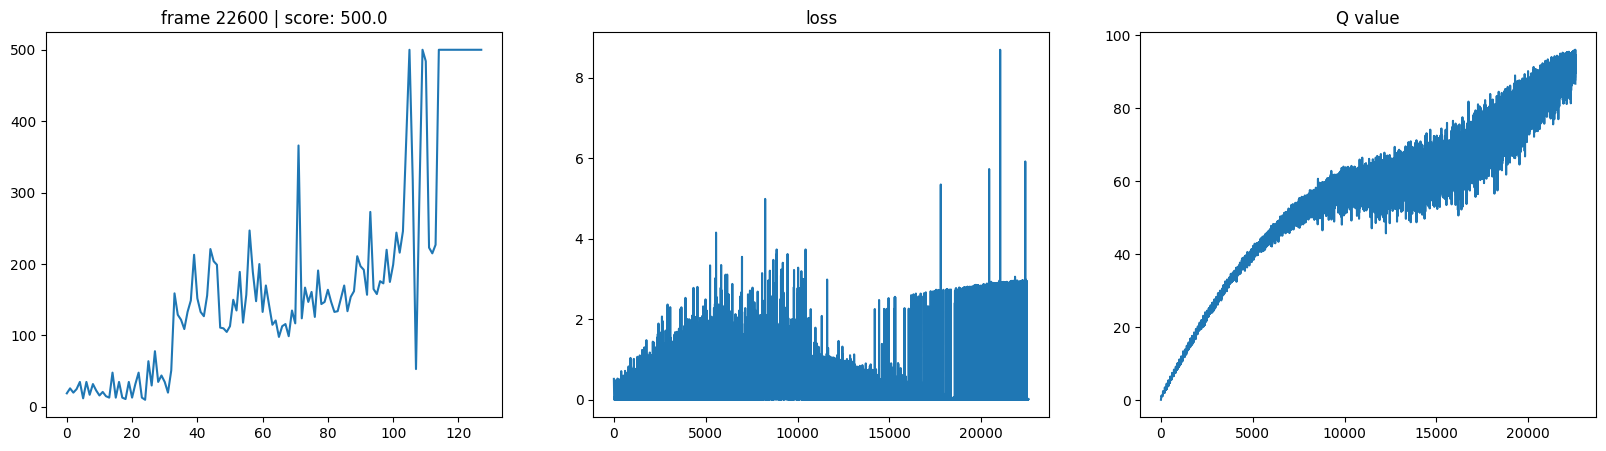

saved state!


In [124]:
agent.train(seed, num_frames)

In [185]:
video_folder = 'videos'
env_w_video = gym.make(env_id, render_mode="rgb_array")
# TODO: add some way to initialize with low epsilon without having to instantiate a new DQNAgent
# NOTE: epsilon is disabled while testing
agent = DQNAgent(env_w_video, seed, memory_size, batch_size, target_update, epsilon_decay)
saved_sd = torch.load(f'saved-state-{seed}.pt') 
agent.load_state(saved_sd)
agent.test(video_folder)

Moviepy - Building video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4.
Moviepy - Writing video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4


Moviepy - Building video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4.
Moviepy - Writing video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4
score:  500.0


# Position bias
I thought it would be cool to implement something such that the cart would try to stick to some defined x position!
Input a range between `[-1, 1]` on `PositionBiasWrapper(env, range)`.
Sadly it didn't work because it drifts away into the distance in an attempt to equilibrate the pole back. See `video/rl-video-episode-0-bias.mp4`

In [179]:
class PositionBiasWrapper(gym.Wrapper):
    def __init__(self, env, bias):
        super().__init__(env)
        self.bias = bias
        self.right_edge = self.observation_space.high[0]
        # assuming center is at 0 and both sides are symmetrical - may have to edit this for other environments
        self.pos_range = self.right_edge

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        # we use self.range to "squish" the cart position between the range [-1, 1]
        pos = obs[0] / self.pos_range
        distance = abs(pos - self.bias)
        reward -= sin(distance)
        return obs, reward, terminated, truncated, info

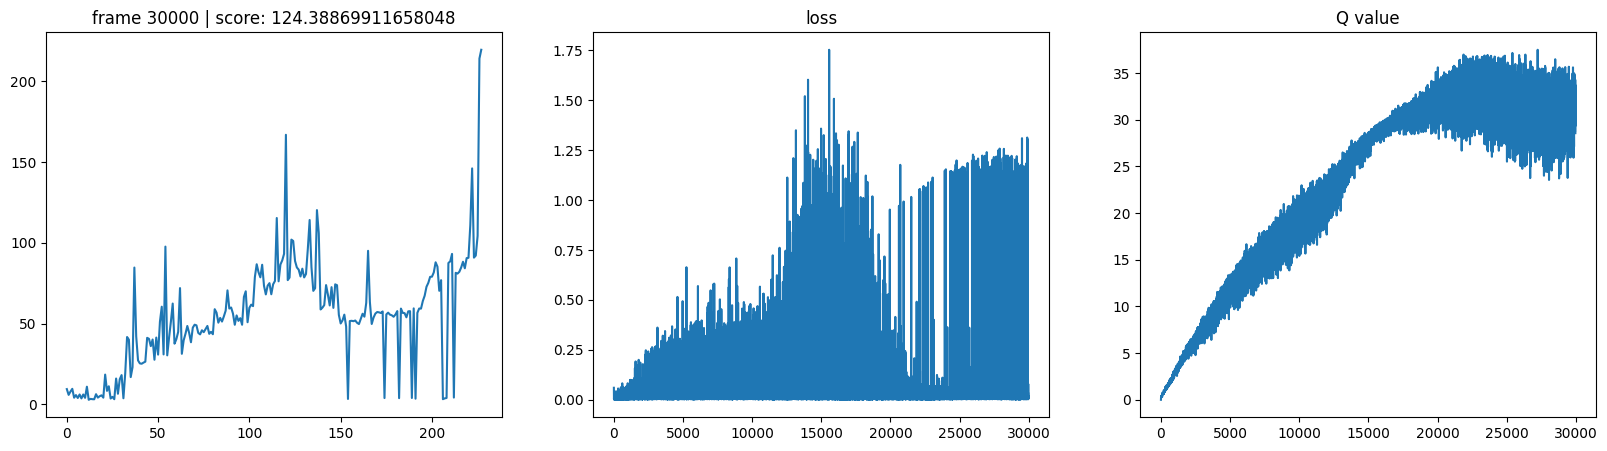

saved state!


In [180]:
num_frames = 30_000
memory_size = 1_000
batch_size = 32
target_update = 100
epsilon_decay = 1/2000

env = PositionBiasWrapper(env_w_video, -.7)
agent = DQNAgent(env, seed, memory_size, batch_size, target_update, epsilon_decay)
agent.train(seed, num_frames)

In [181]:
video_folder = 'videos'
env_w_video = gym.make(env_id, render_mode="rgb_array")
# TODO: add some way to initialize with low epsilon without having to instantiate a new DQNAgent
# NOTE: epsilon is disabled while testing
agent = DQNAgent(env_w_video, seed, memory_size, batch_size, target_update, epsilon_decay)
saved_sd = torch.load(f'saved-state-bias.pt') 
agent.load_state(saved_sd)
agent.test(video_folder)

d:\local\software\Python\Python311\Lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at d:\projects\programming\py\ai\rainbow\src\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4.
Moviepy - Writing video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4


Moviepy - Building video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4.
Moviepy - Writing video d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\projects\programming\py\ai\rainbow\src\videos\rl-video-episode-0.mp4
score:  117.0
